<a href="https://colab.research.google.com/github/shivamsouravjha/Toonification/blob/main/Discriminator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
from tensorflow import keras
import cv2
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.models import load_model
import math
import numpy as np
import pathlib
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.python.framework import ops
from keras.models import Sequential # to create a cnn model
import tensorflow_addons as tfa
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop,Adam,SGD,Adagrad,Adadelta,Adamax,Nadam
from keras.applications import xception
from keras.layers import LeakyReLU


In [42]:
import tensorflow as tf
from typeguard import typechecked


@tf.keras.utils.register_keras_serializable(package="Addons")
class SpectralNormalization(tf.keras.layers.Wrapper):
    """Performs spectral normalization on weights.
    This wrapper controls the Lipschitz constant of the layer by
    constraining its spectral norm, which can stabilize the training of GANs.
    See [Spectral Normalization for Generative Adversarial Networks](https://arxiv.org/abs/1802.05957).
    ```python
    net = SpectralNormalization(
        tf.keras.layers.Conv2D(2, 2, activation="relu"),
        input_shape=(32, 32, 3))(x)
    net = SpectralNormalization(
        tf.keras.layers.Conv2D(16, 5, activation="relu"))(net)
    net = SpectralNormalization(
        tf.keras.layers.Dense(120, activation="relu"))(net)
    net = SpectralNormalization(
        tf.keras.layers.Dense(n_classes))(net)
    ```
    Arguments:
      layer: A `tf.keras.layers.Layer` instance that
        has either `kernel` or `embeddings` attribute.
      power_iterations: `int`, the number of iterations during normalization.
    Raises:
      AssertionError: If not initialized with a `Layer` instance.
      ValueError: If initialized with negative `power_iterations`.
      AttributeError: If `layer` does not has `kernel` or `embeddings` attribute.
    """

    @typechecked
    def __init__(self, layer: tf.keras.layers, power_iterations: int = 1, **kwargs):
        super().__init__(layer, **kwargs)
        if power_iterations <= 0:
            raise ValueError(
                "`power_iterations` should be greater than zero, got "
                "`power_iterations={}`".format(power_iterations)
            )
        self.power_iterations = power_iterations
        self._initialized = False

    def build(self, input_shape):
        """Build `Layer`"""
        super().build(input_shape)
        input_shape = tf.TensorShape(input_shape)
        self.input_spec = tf.keras.layers.InputSpec(shape=[None] + input_shape[1:])

        if hasattr(self.layer, "kernel"):
            self.w = self.layer.kernel
        elif hasattr(self.layer, "embeddings"):
            self.w = self.layer.embeddings
        else:
            raise AttributeError(
                "{} object has no attribute 'kernel' nor "
                "'embeddings'".format(type(self.layer).__name__)
            )

        self.w_shape = self.w.shape.as_list()

        self.u = self.add_weight(
            shape=(1, self.w_shape[-1]),
            initializer=tf.initializers.TruncatedNormal(stddev=0.02),
            trainable=False,
            name="sn_u",
            dtype=self.w.dtype,
        )

    def call(self, inputs, training=None):
        """Call `Layer`"""
        if training is None:
            training = tf.keras.backend.learning_phase()

        if training:
            self.normalize_weights()

        output = self.layer(inputs)
        return output

    def compute_output_shape(self, input_shape):
        return tf.TensorShape(self.layer.compute_output_shape(input_shape).as_list())

    @tf.function
    def normalize_weights(self):
        """Generate spectral normalized weights.
        This method will update the value of `self.w` with the
        spectral normalized value, so that the layer is ready for `call()`.
        """

        w = tf.reshape(self.w, [-1, self.w_shape[-1]])
        u = self.u

        with tf.name_scope("spectral_normalize"):
            for _ in range(self.power_iterations):
                v = tf.math.l2_normalize(tf.matmul(u, w, transpose_b=True))
                u = tf.math.l2_normalize(tf.matmul(v, w))

            sigma = tf.matmul(tf.matmul(v, w), u, transpose_b=True)

            self.w.assign(self.w / sigma)
            self.u.assign(u)

    def get_config(self):
        config = {"power_iterations": self.power_iterations}
        base_config = super().get_config()
        return {**base_config, **config}

In [47]:
def boxx(a ,k,n,s):
  x1 = SpectralNormalization( Conv2D(n, (k,k),strides=(s,s), padding='same'))(a)
  x1 = LeakyReLU()(x1)
  return x1


In [53]:
input_img = Input(shape=(64,64,1))
x1 = boxx(input_img,32,2,2)
x1 = boxx(x1,32,2,1)
x1 = boxx(x1,64,2,2)
x1 = boxx(x1,64,2,1)
x1 = boxx(x1,128,2,2)
x1 = boxx(x1,128,2,1)
x1 = Conv2D(1,(1,1),strides=(1,1),padding='same')(x1) 

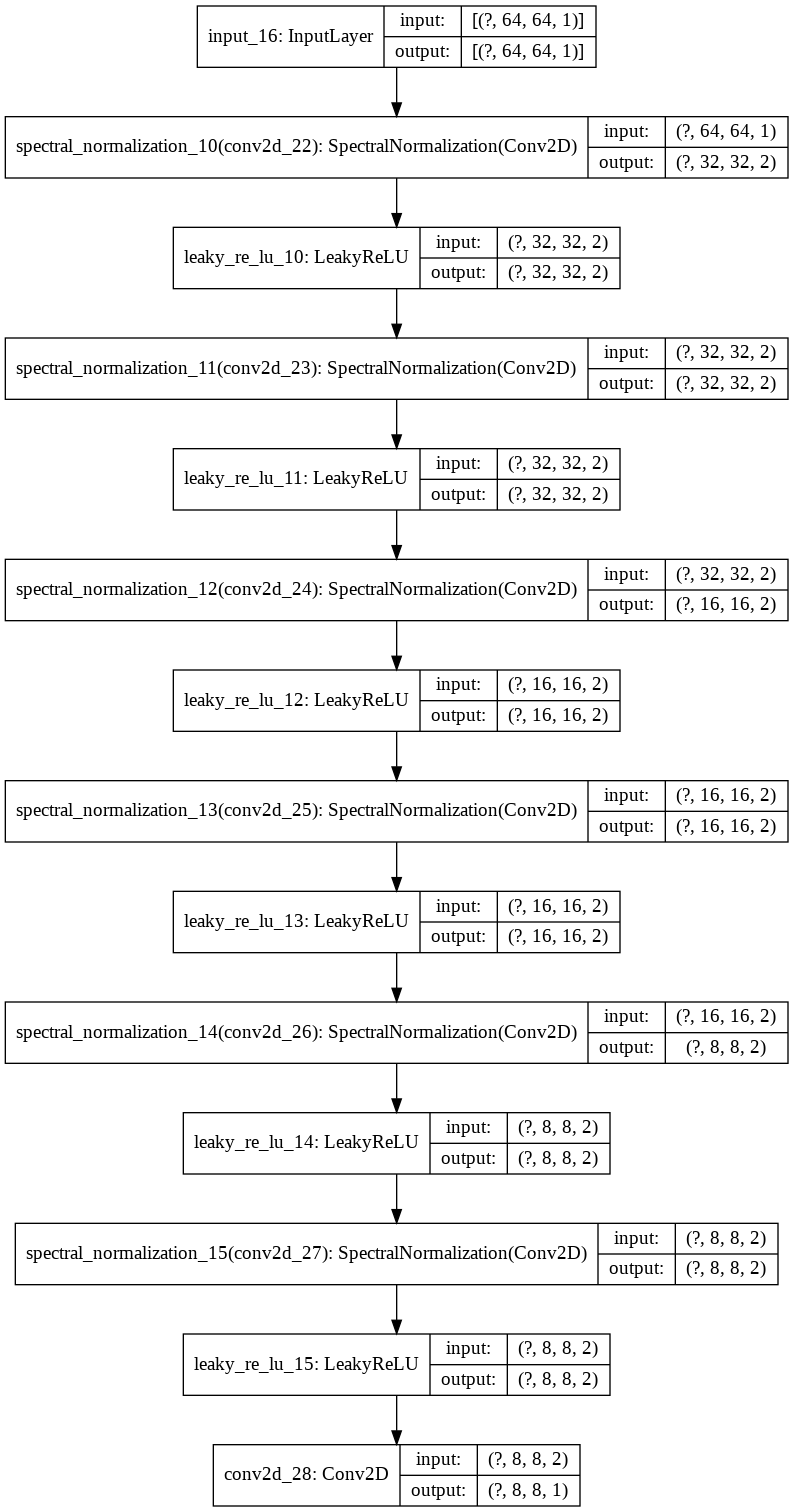

In [54]:
autoencoder =Model(input_img,x1)

from tensorflow.keras.utils import plot_model
plot_model(autoencoder, to_file='model.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image("model.png")

